In [1]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import ale_py  as ale
from PIL import Image
from collections import deque
import os
from torch.utils.tensorboard import SummaryWriter
from tqdm import trange
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

In [2]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
print("Action space:", env.action_space)
print("Observation space:", env.observation_space)

Action space: Discrete(2)
Observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)


In [3]:
class Actor(nn.Module):
    def __init__(self, obs_dim, n_actions):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(obs_dim, 128)
        self.fc2 = nn.Linear(128, n_actions)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)
        return logits

In [4]:
class Critic(nn.Module):
    def __init__(self, obs_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(obs_dim, 128)
        self.fc2 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        value = self.fc2(x)
        return value

In [5]:
obs = env.reset()[0]
obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
print("Initial observation:", obs_tensor)
print("Observation tensor shape:", obs_tensor.shape)

Initial observation: tensor([[ 0.0295,  0.0336, -0.0326, -0.0075]])
Observation tensor shape: torch.Size([1, 4])


In [6]:
actor = Actor(4,2)
critic = Critic(4)

logits = actor(obs_tensor)
value = critic(obs_tensor)

print("Actor logits:", logits)
print("Value:", value)

Actor logits: tensor([[0.1868, 0.1096]], grad_fn=<AddmmBackward0>)
Value: tensor([[-0.0673]], grad_fn=<AddmmBackward0>)


In [7]:
def select_action(actor, obs):
    logits = actor(obs)
    dist = Categorical(logits=logits)
    action = dist.sample()
    log_prob = dist.log_prob(action)
    entropy = dist.entropy()
    return action.item(), log_prob, entropy

In [8]:
action, log_prob, entropy = select_action(actor, obs_tensor)

print("Action:", action)
print("Log prob:", log_prob)
print("Entropy:", entropy)


Action: 0
Log prob: tensor([-0.6553], grad_fn=<SqueezeBackward1>)
Entropy: tensor([0.6924], grad_fn=<NegBackward0>)


In [9]:
#setting up the env
env = gym.make("CartPole-v1")
actor = Actor(env.observation_space.shape[0],env.action_space.n)
critic = Critic(env.observation_space.shape[0])

In [10]:
episodes = 300
gamma = 0.99

actor_optimizer = torch.optim.Adam(actor.parameters(), lr=1e-4)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=1e-3)

entropy_coef = 0.01


Episode 0, Reward: 15.0, Actor Loss: 9.066, Critic Loss: 14.085, Entropy: 10.117
Episode 1, Reward: 17.0, Actor Loss: 9.043, Critic Loss: 17.133, Entropy: 11.086
Episode 2, Reward: 11.0, Actor Loss: 5.190, Critic Loss: 11.517, Entropy: 6.848
Episode 3, Reward: 10.0, Actor Loss: 3.651, Critic Loss: 12.821, Entropy: 5.838
Episode 4, Reward: 12.0, Actor Loss: 4.714, Critic Loss: 16.519, Entropy: 6.768
Episode 5, Reward: 11.0, Actor Loss: 4.161, Critic Loss: 15.966, Entropy: 5.965
Episode 6, Reward: 11.0, Actor Loss: 3.087, Critic Loss: 21.836, Entropy: 5.487
Episode 7, Reward: 15.0, Actor Loss: 6.346, Critic Loss: 24.097, Entropy: 7.695
Episode 8, Reward: 14.0, Actor Loss: 4.953, Critic Loss: 26.974, Entropy: 6.753
Episode 9, Reward: 12.0, Actor Loss: 3.440, Critic Loss: 28.024, Entropy: 5.689
Episode 10, Reward: 10.0, Actor Loss: 1.470, Critic Loss: 37.543, Entropy: 4.386
Episode 11, Reward: 10.0, Actor Loss: 2.309, Critic Loss: 29.398, Entropy: 4.475
Episode 12, Reward: 9.0, Actor Loss:

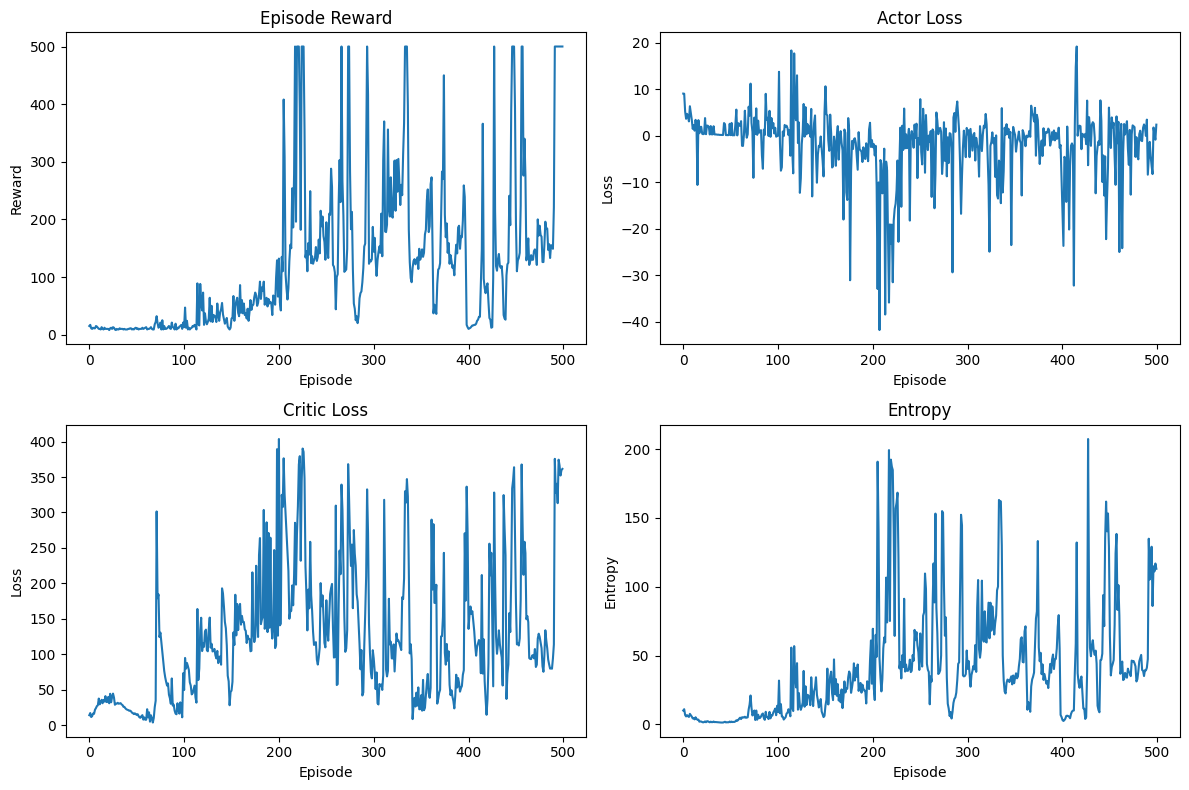

In [11]:
import matplotlib.pyplot as plt

#setting up the env
env = gym.make("CartPole-v1")
actor = Actor(env.observation_space.shape[0],env.action_space.n)
critic = Critic(env.observation_space.shape[0])

episodes = 500
gamma = 0.95

actor_optimizer = torch.optim.Adam(actor.parameters(), lr=1e-3)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=1e-3)

entropy_coef = 0.0
# Storage for logs
reward_log = []
actor_loss_log = []
critic_loss_log = []
entropy_log = []

for episode in range(episodes):

    state, _ = env.reset()
    done = False
    episode_reward = 0
    episode_actor_loss = 0.0
    episode_critic_loss = 0.0
    episode_entropy = 0.0

    entropy_coef = max(0.0, 0.01 * (1 - episode/episodes))

    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

        action, log_prob, entropy = select_action(actor, state_tensor)
        value = critic(state_tensor)

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

        with torch.no_grad():
            if done:
                y = torch.tensor([[reward]], dtype=torch.float32)
            else:
                y = reward + gamma * critic(next_state_tensor)

        advantage = y - value
        # advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-8)
        
        # Actor loss
        actor_loss = -log_prob * advantage.detach() - entropy_coef * entropy

        # Critic loss
        critic_loss = advantage.pow(2)

        # Update actor
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        # Update critic
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()
        
        torch.nn.utils.clip_grad_norm_(actor.parameters(), 0.5)
        torch.nn.utils.clip_grad_norm_(critic.parameters(), 0.5)


        # Logging
        episode_reward += reward
        episode_actor_loss += actor_loss.item()
        episode_critic_loss += critic_loss.item()
        episode_entropy += entropy.item()
        state = next_state

    # Append episode stats
    reward_log.append(episode_reward)
    actor_loss_log.append(episode_actor_loss)
    critic_loss_log.append(episode_critic_loss)
    entropy_log.append(episode_entropy)

    print(f"Episode {episode}, Reward: {episode_reward}, "
          f"Actor Loss: {episode_actor_loss:.3f}, "
          f"Critic Loss: {episode_critic_loss:.3f}, "
          f"Entropy: {episode_entropy:.3f}")

# Plotting after training
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(reward_log)
plt.title('Episode Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')

plt.subplot(2,2,2)
plt.plot(actor_loss_log)
plt.title('Actor Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')

plt.subplot(2,2,3)
plt.plot(critic_loss_log)
plt.title('Critic Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')

plt.subplot(2,2,4)
plt.plot(entropy_log)
plt.title('Entropy')
plt.xlabel('Episode')
plt.ylabel('Entropy')

plt.tight_layout()
plt.show()


In [15]:
import torch

# Define the file paths
ACTOR_PATH = "actor_model.pth"
CRITIC_PATH = "critic_model.pth"

# Save the state dictionaries
torch.save(actor.state_dict(), ACTOR_PATH)
torch.save(critic.state_dict(), CRITIC_PATH)

print(f"Models saved to {ACTOR_PATH} and {CRITIC_PATH}")

Models saved to actor_model.pth and critic_model.pth


In [16]:
# 1. Re-create the model architectures
loaded_actor = Actor(env.observation_space.shape[0], env.action_space.n)
loaded_critic = Critic(env.observation_space.shape[0])

# 2. Load the saved weights
loaded_actor.load_state_dict(torch.load("actor_model.pth"))
loaded_critic.load_state_dict(torch.load("critic_model.pth"))

# 3. Set to evaluation mode if only using for inference
loaded_actor.eval()
loaded_critic.eval()

C:\Users\91930\AppData\Local\Temp\ipykernel_22584\3679712724.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_actor.load_state_dict(torch.load("actor_model.pth"))


Critic(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [17]:
# Set networks to evaluation mode
# actor.eval()
# critic.eval()

eval_env = gym.make("CartPole-v1", render_mode="rgb_array")
num_eval_episodes = 5
eval_rewards = []

for episode in range(num_eval_episodes):
    state, _ = eval_env.reset()
    done = False
    episode_reward = 0

    while not done:
        eval_env.render()
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

        with torch.no_grad():  # no grads needed
            logits = loaded_actor(state_tensor)
            # Take deterministic action: argmax
            action = torch.argmax(logits, dim=1).item()
            value = loaded_critic(state_tensor)

        next_state, reward, terminated, truncated, _ = eval_env.step(action)
        done = terminated or truncated
        episode_reward += reward
        state = next_state

    eval_rewards.append(episode_reward)
    print(f"Eval Episode {episode}, Reward: {episode_reward}")

mean_reward = sum(eval_rewards)/num_eval_episodes
print(f"Average Reward over {num_eval_episodes} episodes: {mean_reward}")

# Optional: render

# eval_env.reset()


Eval Episode 0, Reward: 500.0
Eval Episode 1, Reward: 500.0
Eval Episode 2, Reward: 500.0
Eval Episode 3, Reward: 500.0
Eval Episode 4, Reward: 500.0
Average Reward over 5 episodes: 500.0


In [13]:
import torch
from PIL import Image
from IPython.display import display, Image as IPImage, clear_output

def visualize_agent_gif(actor, env, episodes=1, delay=0.05, gif_path="agent.gif"):
    """
    Visualize a trained agent using rgb_array frames and save as GIF.
    """
    actor.eval()
    all_frames = []

    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0
        frames = []

        while not done:
            # Render frame as RGB array
            frame = env.render()
            frames.append(Image.fromarray(frame))

            # Optional: display inline while running
            img = Image.fromarray(frame)
            # display(img)
            # clear_output(wait=True)

            # Prepare state
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                logits = actor(state_tensor)
                action = torch.argmax(logits, dim=1).item()

            # Step environment
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            state = next_state

        print(f"Episode {ep+1}, Reward: {episode_reward}")
        all_frames.extend(frames)

    # Save all collected frames as a GIF
    all_frames[0].save(
        gif_path,
        save_all=True,
        append_images=all_frames[1:],
        duration=int(delay*1000),  # duration per frame in ms
        loop=0
    )
    env.close()
    print(f"Saved GIF to {gif_path}")

    # Display GIF in notebook
    display(IPImage(filename=gif_path))


Episode 1, Reward: 500.0
Saved GIF to agent_2.gif


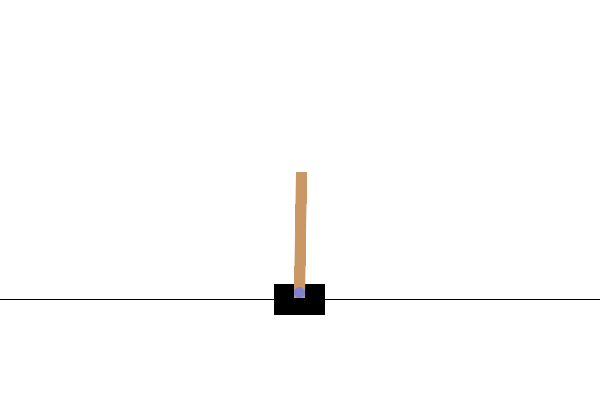

In [14]:
visualize_agent_gif(actor, eval_env, episodes=1, delay=0.0, gif_path="agent_2.gif")

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# TensorBoard writer
writer = SummaryWriter(log_dir="runs/cartpole_ac")

# setting up the env
env = gym.make("CartPole-v1")
actor = Actor(env.observation_space.shape[0], env.action_space.n)
critic = Critic(env.observation_space.shape[0])

episodes = 300
gamma = 0.99

actor_optimizer = torch.optim.Adam(actor.parameters(), lr=1e-4)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=1e-3)

entropy_coef = 0.0

for episode in range(episodes):

    state, _ = env.reset()
    done = False
    episode_reward = 0
    episode_actor_loss = 0.0
    episode_critic_loss = 0.0
    episode_entropy = 0.0

    # decay entropy coefficient
    entropy_coef = max(0.0, 0.01 * (1 - episode / episodes))

    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

        action, log_prob, entropy = select_action(actor, state_tensor)
        value = critic(state_tensor)

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

        with torch.no_grad():
            if done:
                y = torch.tensor([[reward]], dtype=torch.float32)
            else:
                y = reward + gamma * critic(next_state_tensor)

        advantage = y - value

        # Actor loss
        actor_loss = -log_prob * advantage.detach() - entropy_coef * entropy

        # Critic loss
        critic_loss = 0.5 * advantage.pow(2)

        # Update actor
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        # Update critic
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

        # Logging for episode
        episode_reward += reward
        episode_actor_loss += actor_loss.item()
        episode_critic_loss += critic_loss.item()
        episode_entropy += entropy.item()
        state = next_state

    # Write to TensorBoard
    writer.add_scalar("Reward", episode_reward, episode)
    writer.add_scalar("Actor Loss", episode_actor_loss, episode)
    writer.add_scalar("Critic Loss", episode_critic_loss, episode)
    writer.add_scalar("Entropy", episode_entropy, episode)

    print(f"Episode {episode}, Reward: {episode_reward}, "
          f"Actor Loss: {episode_actor_loss:.3f}, "
          f"Critic Loss: {episode_critic_loss:.3f}, "
          f"Entropy: {episode_entropy:.3f}")

# Close the writer after training
writer.close()
